# Pergunta:

## Peso, altura e idade influenciam se o atleta ganha medalha?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats

In [3]:
df = pd.read_csv('C:\\01-FaculdadeSemestreAtual\\Projeto_Integrador_VI\\Datasets\\athlete_events.csv')

df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [5]:
df.isnull().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

In [6]:
df.shape

(271116, 15)

# Tratamento de dados

## Preenchendo valores nulos

In [7]:
# Calcular a média de Height e Weight para cada atleta (Name)
mean_values_atleta = df.groupby('Name')[['Height', 'Weight']].mean()

# Calcular a média de Height e Weight para cada evento
mean_values_evento = df.groupby('Event')[['Height', 'Weight']].mean()

# Calcular a média geral do DataFrame
mean_height_geral = df['Height'].mean()
mean_weight_geral = df['Weight'].mean()

# Função para calcular a mediana de idade por esporte e ano
median_age_by_year_sport = df.groupby(['Year', 'Sport'])['Age'].median()

# Mediana geral de idade para o DataFrame
median_age_geral = df['Age'].median()

# Função para preencher os valores de Height e Weight
def preencher_valores(row):
    # Se o valor de Height for nulo
    if pd.isnull(row['Height']):
        # Tentar preencher com a média do atleta
        if not pd.isnull(mean_values_atleta.loc[row['Name'], 'Height']):
            row['Height'] = mean_values_atleta.loc[row['Name'], 'Height']
        # Se a média do atleta for nula, preencher com a média do evento
        elif not pd.isnull(mean_values_evento.loc[row['Event'], 'Height']):
            row['Height'] = mean_values_evento.loc[row['Event'], 'Height']
        # Se ainda for nulo, preencher com a média geral
        else:
            row['Height'] = mean_height_geral

    # Se o valor de Weight for nulo
    if pd.isnull(row['Weight']):
        # Tentar preencher com a média do atleta
        if not pd.isnull(mean_values_atleta.loc[row['Name'], 'Weight']):
            row['Weight'] = mean_values_atleta.loc[row['Name'], 'Weight']
        # Se a média do atleta for nula, preencher com a média do evento
        elif not pd.isnull(mean_values_evento.loc[row['Event'], 'Weight']):
            row['Weight'] = mean_values_evento.loc[row['Event'], 'Weight']
        # Se ainda for nulo, preencher com a média geral
        else:
            row['Weight'] = mean_weight_geral

    # Tentar calcular a idade usando o ano de nascimento
    if pd.isnull(row['Age']):
        birth_year = row['Year'] - row['Age'] if not pd.isnull(row['Age']) else None
        if birth_year is None:
            # Usar a mediana da idade por esporte e ano, se existir
            median_age_sport_year = median_age_by_year_sport.get((row['Year'], row['Sport']), None)
            if pd.notnull(median_age_sport_year):
                row['Age'] = median_age_sport_year
            else:
                # Usar a mediana geral de idade
                row['Age'] = median_age_geral
    
    return row

# Aplicar a função em cada linha do dataframe
df = df.apply(preencher_valores, axis=1)


In [8]:
df.isnull().sum()

ID             0
Name           0
Sex            0
Age            0
Height         0
Weight         0
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

In [9]:
# Transformar medalhas em valores numéricos
medal_mapping = {'Gold': 3, 'Silver': 2, 'Bronze': 1}
df['Medal'] = df['Medal'].map(medal_mapping)
df['Medal'].fillna(0, inplace=True)  # Preencher NaN (sem medalha) com 0

C:\Users\guiro\AppData\Local\Temp\ipykernel_31380\4169830129.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Medal'].fillna(0, inplace=True)  # Preencher NaN (sem medalha) com 0


# Random Forest

In [10]:
# Selecionar features e target
X = df[['Age', 'Height', 'Weight']]
y = df['Medal']

# Separar em dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Modelo Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Avaliação do Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.91     69375
         1.0       0.09      0.01      0.02      3954
         2.0       0.13      0.02      0.04      3919
         3.0       0.17      0.03      0.05      4087

    accuracy                           0.84     81335
   macro avg       0.31      0.26      0.26     81335
weighted avg       0.75      0.84      0.79     81335



# Regressão Linear

In [11]:
# Modelo de Regressão Linear
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Avaliação da Regressão Linear
mse = mean_squared_error(y_test, y_pred_lr)
print(f"Mean Squared Error - Regressão Linear: {mse}")

Mean Squared Error - Regressão Linear: 0.6019654181666795


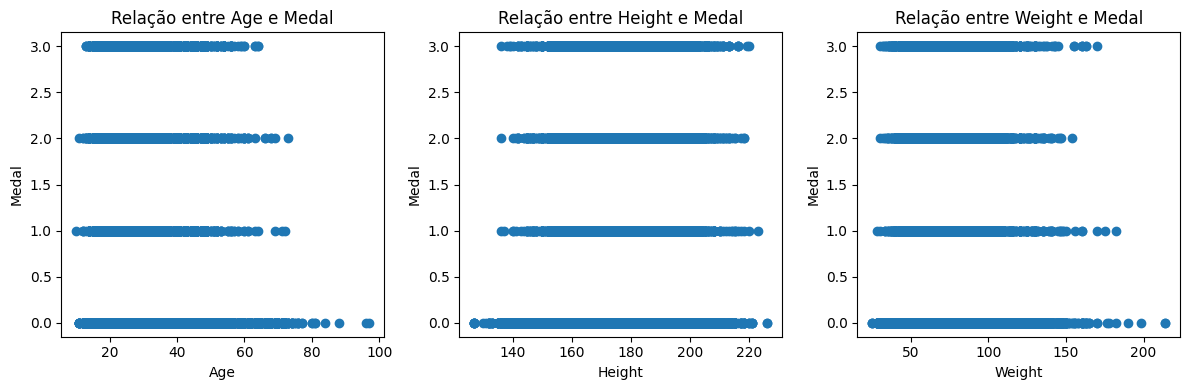

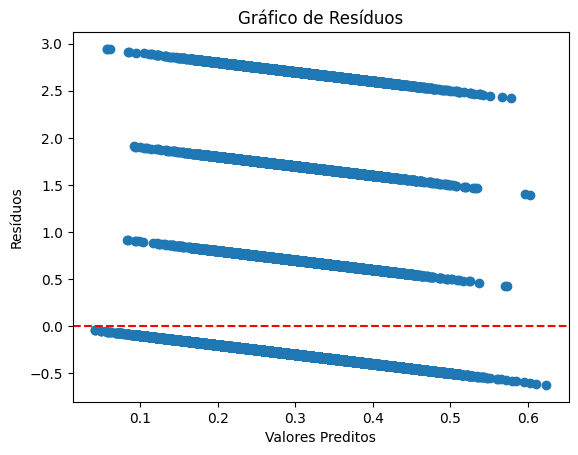

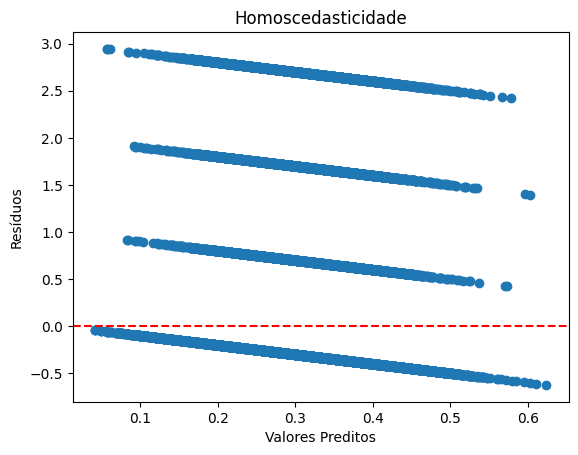

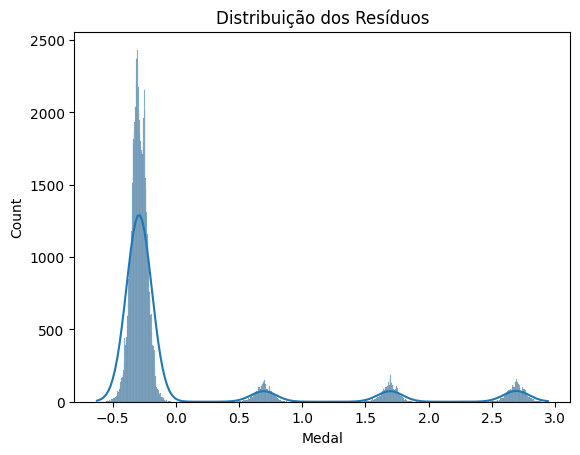

Teste de Shapiro-Wilk para Normalidade dos Resíduos: ShapiroResult(statistic=np.float64(0.49584824943136574), pvalue=np.float64(1.6295825249169983e-155))
  Feature        VIF
0     Age  16.981854
1  Height  59.284542
2  Weight  46.756785


c:\01-FaculdadeSemestreAtual\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 81335.
  res = hypotest_fun_out(*samples, **kwds)


In [12]:
# 3. Análises das suposições do modelo

# 3.1 Verifique se há relação linear entre a variável dependente e as variáveis independentes
plt.figure(figsize=(12, 4))
for i, col in enumerate(X_train.columns):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X_train[col], y_train)
    plt.title(f'Relação entre {col} e Medal')
    plt.xlabel(col)
    plt.ylabel('Medal')
plt.tight_layout()
plt.show()

# 3.2 Certifique-se de que os erros do modelo sejam independentes (usando gráfico de resíduos)
residuals = y_test - y_pred_lr
plt.scatter(y_pred_lr, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Gráfico de Resíduos')
plt.show()

# 3.3 Verifique se a variância dos erros é constante (Homoscedasticidade)
plt.scatter(y_pred_lr, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Homoscedasticidade')
plt.show()

# 3.4 Verifique se os erros seguem uma distribuição normal
sns.histplot(residuals, kde=True)
plt.title('Distribuição dos Resíduos')
plt.show()

# Teste de normalidade (Shapiro-Wilk)
shapiro_test = stats.shapiro(residuals)
print(f"Teste de Shapiro-Wilk para Normalidade dos Resíduos: {shapiro_test}")

# 3.5 Avaliar a multicolinearidade com VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

In [13]:
# 4. Avaliação do modelo

# Coeficientes e P-valores
X_train_sm = sm.add_constant(X_train)  # Adiciona uma constante para o intercepto
model_sm = sm.OLS(y_train, X_train_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Medal   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     405.2
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          2.12e-262
Time:                        14:34:16   Log-Likelihood:            -2.1983e+05
No. Observations:              189781   AIC:                         4.397e+05
Df Residuals:                  189777   BIC:                         4.397e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4776      0.041    -11.513      0.0

In [14]:
# 5. Validação do modelo

# Se desejar realizar validação cruzada:
cv_scores = cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Validação Cruzada - Mean Squared Error: {-np.mean(cv_scores)}")

Validação Cruzada - Mean Squared Error: 0.5963890441784725


In [15]:
# 6. Interpretação dos Resultados

print("Interpretação:")
for feature, coef in zip(X.columns, lr.coef_):
    print(f"{feature}: coeficiente = {coef}")
    
# Abaixo de p < 0.05 indica significância estatística

Interpretação:
Age: coeficiente = 0.0008891737242828406
Height: coeficiente = 0.0033313593482593223
Weight: coeficiente = 0.0022988284145148484


# Comparar

In [16]:
# Exibir previsões e comparar com valores reais
resultados = pd.DataFrame({'Real': y_test, 'RandomForest_Pred': y_pred_rf, 'LinearRegression_Pred': np.round(y_pred_lr)})
print(resultados)

        Real  RandomForest_Pred  LinearRegression_Pred
32094    1.0                0.0                    0.0
47767    0.0                0.0                    0.0
241115   0.0                0.0                    0.0
149390   0.0                0.0                    0.0
172244   3.0                0.0                    0.0
...      ...                ...                    ...
186006   3.0                0.0                    0.0
105772   0.0                0.0                    0.0
134270   0.0                0.0                    0.0
155396   0.0                0.0                    0.0
249261   2.0                0.0                    0.0

[81335 rows x 3 columns]


In [18]:

# Dados da amostra piloto
amostra_piloto = [20, 21, 35, 39, 45, 45, 48, 56, 57, 60]

# Cálculo do desvio padrão
desvio_padrao = np.std(amostra_piloto)  # ddof=1 para amostra

desvio_padrao


np.float64(13.335666462535722)

# PADRONIZAR USANDO Z-SCORE OU MIN-MAX SCALER

## OLHAR SLIDE 7 DO SÉRGIO